In [1]:
import glob
import chess_DL1_lib as lib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import chess
# import numpy as np

In [2]:
MODEL_NUM = 1
MODEL_VERSION = 2

path = "../Data/DataTrain"

letters_in = 'abcdefghijklmnopqrstuvwx'
letters_out = 'yz'

csv_files1 = []
csv_files2 = []

for let in letters_in:
    csv_files1.extend(glob.glob(f'{path}/Chess_Jan_{let}*'))
    csv_files1.extend(glob.glob(f'{path}/Chess_Feb_{let}*'))
    csv_files1.extend(glob.glob(f'{path}/Chess_Mar_{let}*')) # include in version 1-2

for let_ in letters_out:
    csv_files2.extend(glob.glob(f'{path}/Chess_Jan_{let_}*'))
    csv_files2.extend(glob.glob(f'{path}/Chess_Feb_{let_}*'))
    # csv_files2.extend(glob.glob(f'{path}/Chess_Mar_{let_}*')) # include in version 1-2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Models Trained
```
- DL1   (**Epochs**: 19,    **Optimizer**: Adam,               **LR**: 0.01,  **Train**: Jan_a-to-x,       **Test**: Jan_y-to-z).       **Batchsize**: 20000, **Time Per Epoch**: 130000 s/it
- DL1-2 (**Epochs**: TBD,   **Optimizer**: SGD(Momentum=0.9),  **LR**: 0.035, **Train**: [Jan/Feb]_a-to-x, **Test**: [Jan/Feb]_a-to-x). **Batchsize**: 40000, **Time Per Epoch**: TBD
```

| Version | Epochs | Optimizer    | LR    | Train         | Test          | Shuffle? | Batchsize | Loaded? | Time Per Epoch |    Notes     |
|---------|--------|--------------|-------|---------------|---------------|----------|-----------|---------|----------------|--------------|
| 1       | 19     | Adam         | 0.01  | Jan (a-x)     | Jan (y-z)     | No       | 20000     | No      | 130000 s/it    | Legacy EL9.3 |
| 1-2     |        | SGD(Mom=0.9) | 0.04  | Jan-Feb (a-x) | Jan-Mar (y-z) | Yes      | 50000     | Yes (1) |                |              |
<!-- | 1-3     |        |              |       | Jan-Mar (a-x) | Jan-Mar (y-z) | Yes      | 50000     |         |                |              | -->

In [3]:
# Create a dataset
dataset1 = lib.ChessIterableDataset(csv_files1)
dataset2 = lib.ChessIterableDataset(csv_files2)

# Create a data loader
train_data_loader = DataLoader(dataset1, 
                               batch_size = 50000,
                               shuffle=True, # include in version 1-2
)


val_data_loader = DataLoader(dataset2, 
                             batch_size = 50000,
                              shuffle=True, # include in version 1-2
)

# Create a model
model = lib.EvalNet()

model = torch.load(f'./models_EL/model_DL1.pth') # LOAD PREVIOUS MODEL TOP RESUME TRAINING
model = model.to(device)

criterion = nn.L1Loss() # nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_loss_hist, valid_loss_hist = lib.train(model, train_data_loader, val_data_loader, criterion, optimizer, num_epochs = 15)

Begin Training! (on cuda)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15, Training Loss: 1.22384, Validation Loss: 1.23156


  7%|▋         | 1/15 [69:59:15<979:49:36, 251955.45s/it]

Manual Stop: Finished Training Early!
Finished Training!


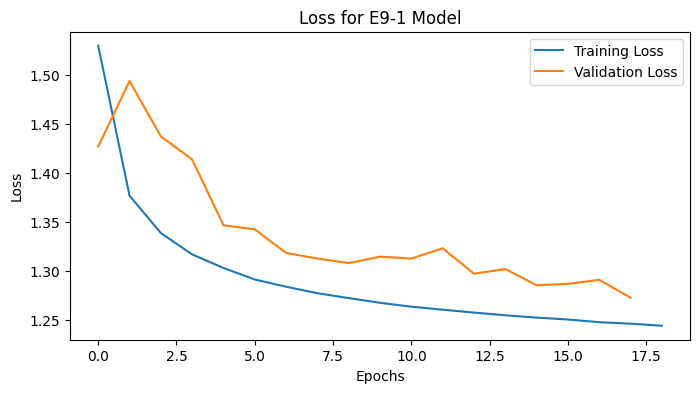

In [ ]:
torch.save(model, f'model_DL{MODEL_NUM}-{MODEL_VERSION}.pth')

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(train_loss_hist, label = 'Training Loss')
plt.plot(valid_loss_hist, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim(0, None)
plt.title(f'Loss for DL{MODEL_NUM}-{MODEL_VERSION} Model')
plt.legend()
plt.savefig(f'Loss_DL{MODEL_NUM}-{MODEL_VERSION}.png')
plt.show()

In [ ]:
import pickle

pickle.dump(train_loss_hist, open(f'pickle/training_loss_history_DL{MODEL_NUM}-{MODEL_VERSION}.pkl', 'wb'))
pickle.dump(valid_loss_hist, open(f'pickle/validation_loss_history_DL{MODEL_NUM}-{MODEL_VERSION}.pkl', 'wb'))

In [ ]:
model_loaded = torch.load(f'model_DL{MODEL_NUM}-{MODEL_VERSION}.pth')

In [ ]:
board = chess.Board()

In [ ]:
move = lib.predict(model_loaded, board.fen())
print(move)
board

In [ ]:
board.push_uci(move)
board

In [ ]:
move = lib.predict(model_loaded, board.fen())

In [ ]:
move = 'e4f6'